In [17]:
import torch
from utils import load_adj_neg, load_dataset_adj_lap
from model import Encoder
from model import Model
import argparse
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import networkx as nx

In [18]:
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pylab as pl
from matplotlib import collections  as mc
def visualize(x,y,labels,lap = None, width = 5):
    ss = 1
    #plt.scatter(emb_pca_x,emb_pca_y,s=ss,color='r')
    label_num = labels.max().item()
    colors = ['r','g','b','c','m','y','k','w']
    if lap is not None:
        a = lap_normalized.to_sparse()._indices()
        lines = [[(x[a[0,i]],y[a[0,i]]),(x[a[1,i]],y[a[1,i]])] for i in range(a.shape[1])]
        lc = mc.LineCollection(lines, colors='k', linewidths=width/10)
        fig, ax = pl.subplots()
        ax.add_collection(lc)
        ax.autoscale()
        ax.margins(0.1)
    for i in range(label_num):
        plt.scatter(x[np.nonzero(labels == i)],y[np.nonzero(labels == i)],s=ss,color=colors[i])
    

In [19]:
# NOTE: Splits are randomized and results might slightly deviate from reported numbers in the paper.
import torch
from utils import load_adj_neg, load_dataset_adj_lap
from ssgc import Net
import argparse
import numpy as np
from classification import classify
parser = argparse.ArgumentParser()
dataset = 'pubmed'
if dataset=='cora':
    nhid = 512
    output = 512
    num_nodes = 2708
    num_features = 1433
    lr = 0.001
    weight_decay = 5e-4
    epoch = 40
    sample = 2
if dataset=='citeseer':
    nhid = 512
    output = 512
    num_nodes = 3327
    num_features = 3703
    lr = 0.0001
    weight_decay = 1e-4
    epoch = 160
    sample = 5
if dataset=='pubmed':
    nhid = 256
    output = 256
    num_nodes = 19717
    num_features = 500
    lr = 0.02
    weight_decay = 1e-5
    epoch = 40
    sample = 3
parser.add_argument('--dataset', type=str, default=dataset,
                    help='dataset')
parser.add_argument('--seed', type=int, default=123,
                    help='seed')
parser.add_argument('--nhid', type=int, default=nhid,
                    help='hidden size')
parser.add_argument('--output', type=int, default=output,
                    help='output size')
parser.add_argument('--lr', type=float, default=lr,
                    help='learning rate')
parser.add_argument('--weight_decay', type=float, default=weight_decay,
                    help='weight decay')
parser.add_argument('--epochs', type=int, default=epoch,
                    help='maximum number of epochs')
parser.add_argument('--sample', type=int, default=sample,
                    help='    ')
parser.add_argument('--num_nodes', type=int, default=num_nodes,
                    help='    ')
parser.add_argument('--num_features', type=int, default=num_features,
                    help='    ')

label_file = open("data/{}{}".format(dataset,"_labels.txt"), 'r')
label_text = label_file.readlines()
labels = []
for line in label_text:
    if line.strip('\n'):
        line = line.strip('\n').split(' ')
        labels.append(int(line[1]))
labels = torch.tensor(labels)


args = parser.parse_args("")
args.device = 'cpu'
torch.manual_seed(args.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

feature, adj_normalized, lap_normalized= load_dataset_adj_lap(args.dataset)
feature = feature.to(device)
adj_normalized = adj_normalized.to(device)
lap_normalized = lap_normalized.to(device)
D = torch.unsqueeze(torch.sum(lap_normalized>0,dim=0),1)



feature_poisson_origin = F.normalize(feature)
feature_poisson_origin = feature_poisson_origin - torch.mean(feature_poisson_origin,dim=0)
feature_smoothed_poisson = torch.zeros(feature.shape)
adj_poisson = (adj_normalized>0)/D
adj_extrinsic_poisson = adj_poisson * (1 - torch.eye(adj_poisson.shape[0]))

for i in range(40):
    feature_smoothed_poisson = feature_poisson_origin/D + torch.mm(adj_extrinsic_poisson, feature_smoothed_poisson)


/mnt/d/time_eternity/desktop_download_doc_pic_vid_music/Desktop/fp_jupyter_conda/coles_orthonormal_and_poisson/coles_mytry/utils.py:193: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))


In [20]:
classify(F.normalize(feature_smoothed_poisson)*(torch.sqrt(D)), args.dataset, per_class='20')
classify(F.normalize(feature_smoothed_poisson)*(torch.sqrt(D)), args.dataset, per_class='5')

78.05755983058633
1.9277719215072078
70.5101843856352
3.7555981539393053


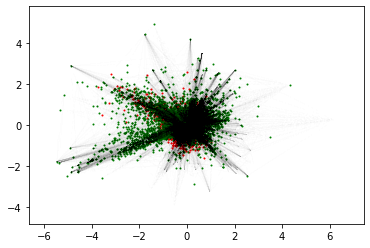

In [21]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA
transformer = decomposition.PCA(n_components=10,
        random_state=0)
feature_pca = transformer.fit_transform(F.normalize(feature_smoothed_poisson)*(torch.sqrt(D)))
#feature_pca = transformer.fit_transform(feature_smoothed_poisson*(torch.sqrt(D)))
visualize(feature_pca[:,2],feature_pca[:,3],labels,lap_normalized,0.01)


In [22]:
classify(feature_smoothed_poisson, args.dataset, per_class='20')
classify(feature_smoothed_poisson, args.dataset, per_class='5')

78.72786651018014
1.5731536347568413
71.48808858637679
3.723149831867699


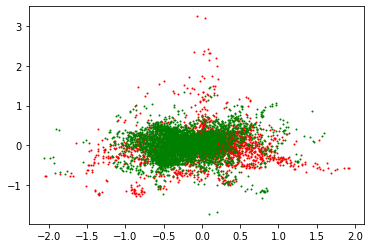

In [23]:

#feature_pca = transformer.fit_transform(F.normalize(feature_smoothed_sgc))
feature_pca = transformer.fit_transform(feature_smoothed_poisson/D)
visualize(feature_pca[:,3],feature_pca[:,4],labels)



In [24]:
cora without orth
82.26276771004942
1.254241627563159
77.16148597422288
2.6389531638400907
with orth
81.75947281713344
1.246101318967512
72.3131159969674
4.046646313156723
with raw feature_smoothed_ssgc
81.59390444810545
1.2038835463852553
71.03032600454888
4.572080755555725

citeseer without orth
70.42112082928408
1.1220317077364168
66.50749923477197
2.431697731089557
with orth
70.94978943958535
1.0752492722237095
66.09978573614937
2.540035128432411
with raw feature_smoothed_ssgc
69.89050858438614
1.2455656779678324
60.153657790021434
4.213946942708061


pubmed without orth
40 epoch
74.67142930040312   claimed 77.4±1.9 
2.381893996454681
64.65291816935033   claimed 66.0±5.2b
5.362018399570344

with ort
40 epoch
74.04715007399092
2.5807319620069507
66.49210138670189
4.908270660412052

raw feature feature_smoothed_ssgc
74.04715007399092
2.5807319620069507
66.49210138670189
4.908270660412052

pubmed 80 epoch wihtout orth
73.68137980303108    
2.4570598828041033
63.52598161223142    
5.489841045145188

pubmed 80 epoch with orth
72.51885492677451
2.5179344333050375
66.14364809264997
4.886909664894386


poisson
cora with sqrt(D)
82.501647446458
1.1428995798576929
76.51099317664897
2.320382303220732
without
81.19439868204284
1.2089103099511311
71.71190295678545
5.642076332418505
citeseer
68.37836086815678
1.469860732902186
62.962350780532596
3.5848155423282355
without
68.10042112082928
1.5459846823114223
60.004285277012556
4.907288919131949

pubmed
78.05755983058633
1.9277719215072078
70.5101843856352
3.7555981539393053
without
78.72786651018014
1.5731536347568413
71.48808858637679
3.723149831867699

SyntaxError: invalid syntax (1956183661.py, line 1)